##### Simulation for Diffuse foreground, 500 point sources, noise and EoR. Adding RFI. Then applying Inpainted data 

##### In this simulation, I add visibilities from 500 pntsrc, diffuse foreground, noise and noise-like EoR. Then I add RFI. Then I make a power spectrum plot using hera_pspec.

In [1]:
from hera_sim.simulate import Simulator
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uvtools
import copy

import hera_pspec as hp
from pyuvdata import UVData

from hera_sim.noise import HERA_Tsky_mdl
from hera_sim.data import DATA_PATH
from hera_sim import eor

/home/anks/.local/lib/python3.7/site-packages/hera_sim-0.1.0-py3.7.egg/hera_sim/visibilities/__init__.py:22: UserWarning: healvis failed to import.
  warnings.warn("healvis failed to import.")
/home/anks/.local/lib/python3.7/site-packages/hera_sim-0.1.0-py3.7.egg/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


### One baseline, 128 frequency channels, 50 times, 16 Hours

In [2]:
sim = Simulator(
    n_freq = 128,
    n_times = 50,
    antennas = {
        0: (20.0, 20.0, 0),
        1: (50.0, 50.0, 0)
    },
    no_autos=True,   # model only one baseline
    integration_time=3600*16./50, # roughly 24 hours of total time
)

In [3]:
sim.antpos

{0: array([ 2.00000000e+01,  2.00000000e+01, -4.53549731e-09]),
 1: array([ 5.00000000e+01,  5.00000000e+01, -4.40831371e-09])}

In [4]:
print(sim.data.get_antpairs())
print(sim.data.get_ants())
print(sim.data.Nbls)
print(sim.data.data_array.shape)

[(0, 1)]
[0 1]
1
(50, 1, 128, 1)


In [5]:
# import matplotlib as mpl
def waterfall(
    vis, freq=sim.data.freq_array[0]/1e6, lsts=sim.data.lst_array, 
    vmax=None, vrange=None, title=None,
):
    """
    A wrapper around the uvtools' waterfall function providing some
    extra labelling and plot adjustment. Specify data in the format 
    data_array[:,0,:,0]
    """
    fig, ax = plt.subplots(
        2,1, sharex=True, sharey=True, figsize=(12,10)
    )
    #vis[:,0,:,0]
    if title is not None:
        ax[0].set_title(title, fontsize=12)
    plt.sca(ax[0])
    imgmag = uvtools.plot.waterfall(
        vis, mode='log', mx=vmax, drng=vrange,
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    #plt.imshow(imgmag.get_array())
    plt.colorbar(label=r'log$_{10}$(Vis/Jy)')
    plt.ylabel("LST", fontsize=12)
    
    plt.sca(ax[1])
    imgphs = uvtools.plot.waterfall(
        vis, 
        mode='phs',
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    
    plt.imshow(imgphs.get_array(), cmap = 'twilight', extent=(freq.min(), freq.max(), lsts.min(), lsts.max()))
    plt.colorbar(label='Phase [rad]')
    plt.xlabel("Frequency [MHz]", fontsize=12)
    plt.ylabel("LST", fontsize=12)

#### Adding Adding Diffuse Foreground, 100 point sources, noise and EoR

In [6]:
sim.add_foregrounds("diffuse_foreground",Tsky_mdl = HERA_Tsky_mdl['xx'])
sim.add_foregrounds("pntsrc_foreground", nsrcs = 500)


noise_vis = sim.add_noise(
    "thermal_noise",
    Tsky_mdl = None,
    Trx = 0.0,
    ret_vis = True,
    Tsky = 10.0
    
)


eor_vis = sim.add_eor(
    model=eor.noiselike_eor,
    ret_vis = True,
    eor_amp=1e-3
)
## eor vis added to sim TRUE by default

In [7]:
# fig1 = plt.figure(figsize=(12,9))
# plt.plot(np.abs(noise_vis[30,0,:,0]))
# plt.ylabel("Visibility [Jy]")
# plt.xlabel("Frequency [MHz]")
# plt.title("Noise for 1 LST bin")   

Text(0.5, 1.0, 'EoR for 1 LST bin')

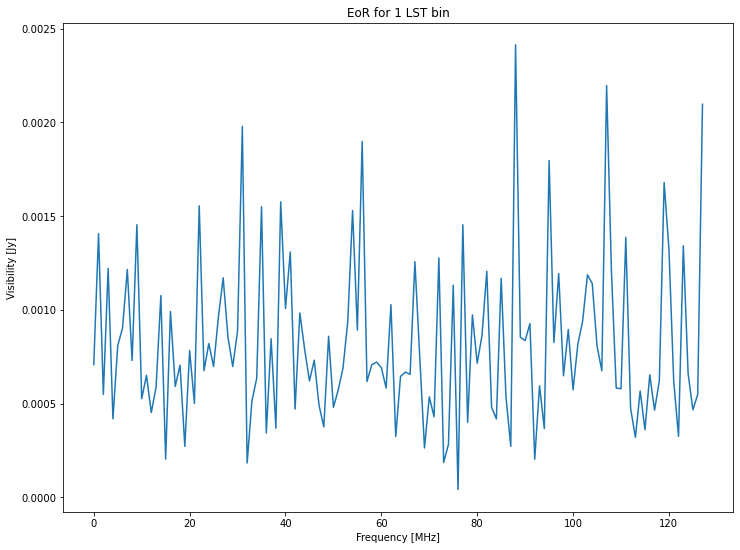

In [8]:
fig2 = plt.figure(figsize=(12,9))
plt.plot(np.abs(eor_vis[30,0,:,0]))
plt.ylabel("Visibility [Jy]")
plt.xlabel("Frequency [MHz]")
plt.title("EoR for 1 LST bin")   

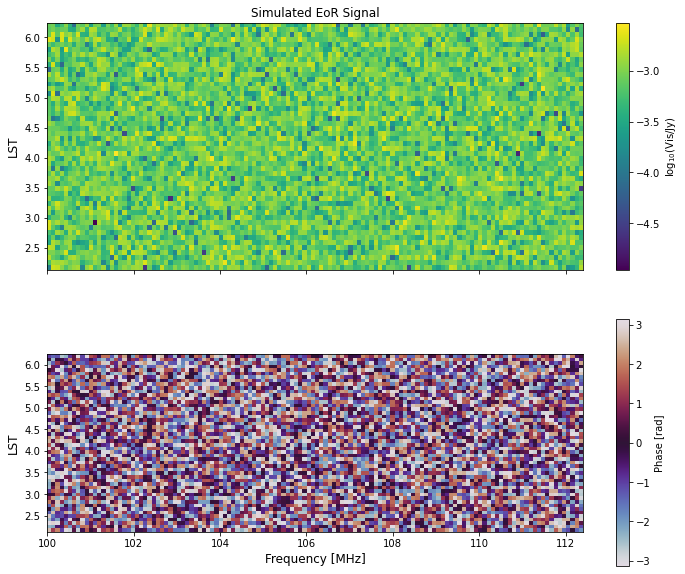

In [9]:
waterfall(eor_vis[:,0,:,0], title='Simulated EoR Signal')


In [10]:
# Load into UVData objects
uvd = copy.deepcopy(sim.data)

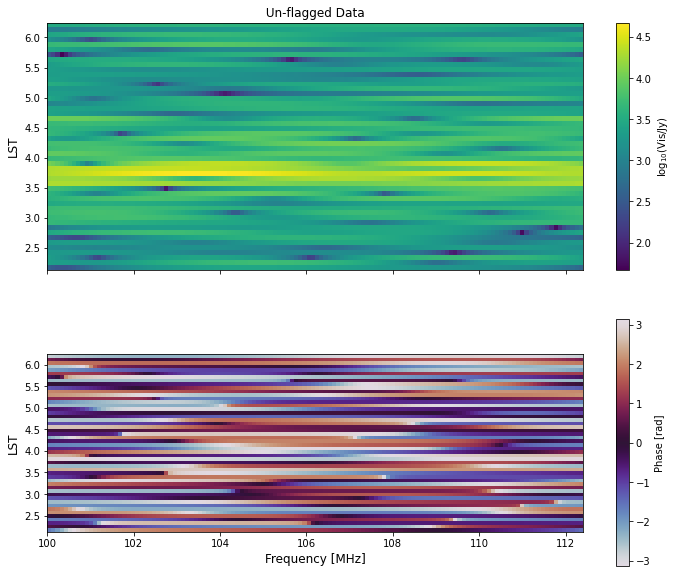

In [11]:
waterfall(uvd.data_array[:,0,:,0], title=' Un-flagged Data ')

### Plot Power Spectrum

In [12]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()

# Load beam model
beamfile = '../data/HERA_NF_dipole_power.beamfits'

uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

# Specify which baselines to include
baselines = [(0,1)]

# we will use the baselines list to produce power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across spectral window between channels 600 -- 700 with identity weighting and a blackman-harris taper
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges= None, 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (0, 128)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Text(0.5, 1.0, 'Unflagged data for 1 LST bin')

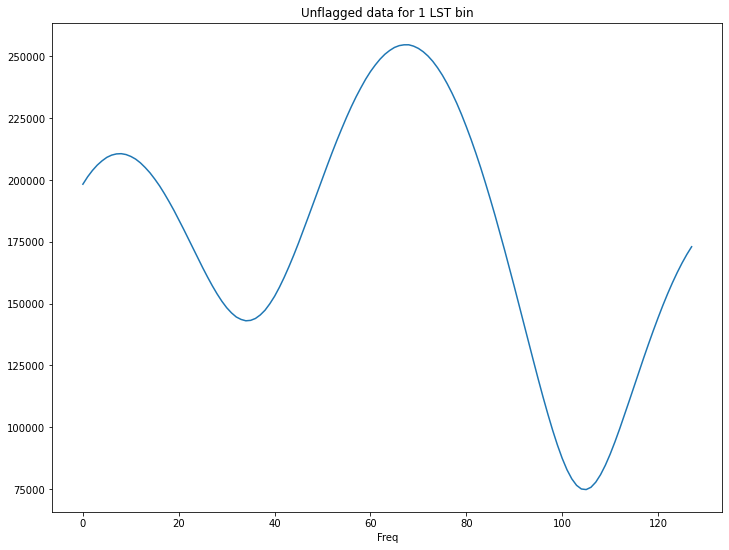

In [13]:
fig3 = plt.figure(figsize=(12,9))
plt.plot(np.abs(uvd.data_array[20,0,:,0]))
plt.xlabel("Freq")
plt.title("Unflagged data for 1 LST bin")   ## in mK

Text(0.5, 1.0, 'Un-flagged data Power Spectrum')

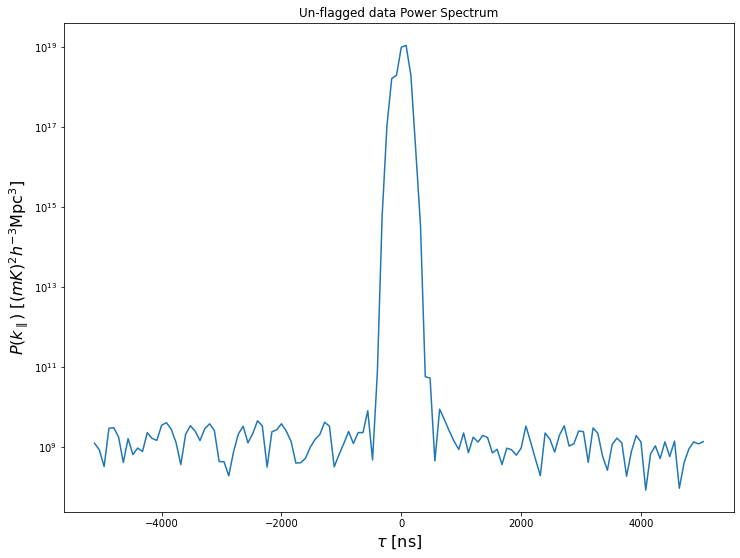

In [14]:
fig4 = plt.figure(figsize=(12,9))
ax4 = fig4.add_subplot(111)
blpairs = np.unique(uvp.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps = [blp for blp in blpairs]

# Plot the spectra averaged over baseline-pairs and times
ax_unflg = hp.plot.delay_spectrum(uvp, [blps,], spw=0, pol=('xx','xx'),
                                  average_blpairs=False, average_times=True, ax = ax4)
ax4.set_title('Un-flagged data Power Spectrum')

Text(0.5, 1.0, 'Unflagged data Power Spectrum')

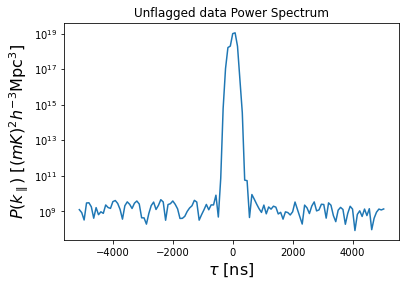

In [15]:
blpairs = np.unique(uvp.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps = [blp for blp in blpairs]

# Plot the spectra averaged over baseline-pairs and times
ax_unflg = hp.plot.delay_spectrum(uvp, [blps,], spw=0, pol=('xx','xx'), average_blpairs=False, average_times=True)
plt.title('Unflagged data Power Spectrum')

### Adding RFI
#### RFI Stations

In [16]:
np.argwhere(sim.data.flag_array[:,0,:,0] == True)

array([], shape=(0, 2), dtype=int64)

In [17]:
np.sort(np.random.randint(1,128,size = 27))

array([  1,   4,   8,   9,  10,  15,  19,  26,  32,  37,  41,  45,  55,
        59,  68,  70,  81,  96,  97,  98, 105, 108, 109, 114, 118, 120,
       127])

In [18]:
# # #Generate RFI
# sim.data.data_array[:,0,2:3,0] = 0
# sim.data.data_array[:,0,4:6,0] = 0
# sim.data.data_array[:,0,8:11,0] = 0
# sim.data.data_array[:,0,16:19,0] = 0
# sim.data.data_array[:,0,26:30,0] = 0
# sim.data.data_array[:,0,38:40,0] = 0
# sim.data.data_array[:,0,44:46,0] = 0 
# sim.data.data_array[:,0,53:59,0] = 0 
# sim.data.data_array[:,0,60:61,0] = 0
# sim.data.data_array[:,0,65:67,0] = 0
# # sim.data.data_array[:,0,74:79,0] = 0
# sim.data.data_array[:,0,88:91,0] = 0
# sim.data.data_array[:,0,94:102,0] = 0
# sim.data.data_array[:,0,113:114,0] = 0

# # Setting the flags
# sim.data.flag_array[:,0,2:3,0] = np.invert(sim.data.flag_array[:,0,2:3,0])
# sim.data.flag_array[:,0,4:6,0] = np.invert(sim.data.flag_array[:,0,4:6,0])
# sim.data.flag_array[:,0,8:11,0] = np.invert(sim.data.flag_array[:,0,8:11,0])
# sim.data.flag_array[:,0,94:102,0] = np.invert(sim.data.flag_array[:,0,94:102,0])
# sim.data.flag_array[:,0,16:19,0] = np.invert(sim.data.flag_array[:,0,16:19,0])
# sim.data.flag_array[:,0,26:30,0] = np.invert(sim.data.flag_array[:,0,26:30,0])
# sim.data.flag_array[:,0,38:40,0] = np.invert(sim.data.flag_array[:,0,38:40,0])
# sim.data.flag_array[:,0,44:46,0] = np.invert(sim.data.flag_array[:,0,44:46,0])
# sim.data.flag_array[:,0,53:59,0] = np.invert(sim.data.flag_array[:,0,53:59,0])
# sim.data.flag_array[:,0,60:61,0] = np.invert(sim.data.flag_array[:,0,60:61,0])
# sim.data.flag_array[:,0,65:67,0] = np.invert(sim.data.flag_array[:,0,65:67,0])
# # sim.data.flag_array[:,0,74:79,0] = np.invert(sim.data.flag_array[:,0,74:79,0])
# sim.data.flag_array[:,0,88:91,0] = np.invert(sim.data.flag_array[:,0,88:91,0])
# sim.data.flag_array[:,0,113:114,0] = np.invert(sim.data.flag_array[:,0,113:114,0])

In [19]:
#Generate RFI
sim.data.data_array[:,0,10:11,0] = 0
sim.data.data_array[:,0,22:24,0] = 0
sim.data.data_array[:,0,36:37,0] = 0
sim.data.data_array[:,0,40:41,0] = 0 
sim.data.data_array[:,0,70:71,0] = 0
sim.data.data_array[:,0,88:89,0] = 0
sim.data.data_array[:,0,111:112,0] = 0
sim.data.data_array[:,0,113:114,0] = 0
sim.data.data_array[:,0,120:121,0] = 0

# Setting the flags
sim.data.flag_array[:,0,10:11,0] = np.invert(sim.data.flag_array[:,0,10:11,0])
sim.data.flag_array[:,0,22:24,0] = np.invert(sim.data.flag_array[:,0,22:24,0])
sim.data.flag_array[:,0,36:37,0] = np.invert(sim.data.flag_array[:,0,36:37,0])
sim.data.flag_array[:,0,40:41,0] = np.invert(sim.data.flag_array[:,0,40:41,0])
sim.data.flag_array[:,0,70:71,0] = np.invert(sim.data.flag_array[:,0,70:71,0])
sim.data.flag_array[:,0,88:89,0] = np.invert(sim.data.flag_array[:,0,88:89,0])
sim.data.flag_array[:,0,111:112,0] = np.invert(sim.data.flag_array[:,0,111:112,0])
sim.data.flag_array[:,0,113:114,0] = np.invert(sim.data.flag_array[:,0,113:114,0])
sim.data.flag_array[:,0,120:121,0] = np.invert(sim.data.flag_array[:,0,120:121,0])

In [20]:
# #Generate RFI
# sim.data.data_array[:,0,2:3,0] = 0
# sim.data.data_array[:,0,4:5,0] = 0
# sim.data.data_array[:,0,8:9,0] = 0
# sim.data.data_array[:,0,14:15,0] = 0
# sim.data.data_array[:,0,16:17,0] = 0
# sim.data.data_array[:,0,26:27,0] = 0
# sim.data.data_array[:,0,31:32,0] = 0
# sim.data.data_array[:,0,38:39,0] = 0
# sim.data.data_array[:,0,44:45,0] = 0 
# sim.data.data_array[:,0,53:54,0] = 0 
# sim.data.data_array[:,0,60:61,0] = 0
# sim.data.data_array[:,0,65:66,0] = 0
# sim.data.data_array[:,0,74:75,0] = 0
# sim.data.data_array[:,0,88:89,0] = 0
# sim.data.data_array[:,0,93:94,0] = 0
# sim.data.data_array[:,0,97:98,0] = 0
# sim.data.data_array[:,0,107:108,0] = 0
# sim.data.data_array[:,0,113:114,0] = 0
# sim.data.data_array[:,0,120:121,0] = 0

# # Setting the flags
# sim.data.flag_array[:,0,2:3,0] = np.invert(sim.data.flag_array[:,0,2:3,0])
# sim.data.flag_array[:,0,4:5,0] = np.invert(sim.data.flag_array[:,0,4:5,0])
# sim.data.flag_array[:,0,8:9,0] = np.invert(sim.data.flag_array[:,0,8:9,0])
# sim.data.flag_array[:,0,14:15,0] = np.invert(sim.data.flag_array[:,0,14:15,0])
# sim.data.flag_array[:,0,16:17,0] = np.invert(sim.data.flag_array[:,0,16:17,0])
# sim.data.flag_array[:,0,26:27,0] = np.invert(sim.data.flag_array[:,0,26:27,0])
# sim.data.flag_array[:,0,31:32,0] = np.invert(sim.data.flag_array[:,0,31:32,0])
# sim.data.flag_array[:,0,38:39,0] = np.invert(sim.data.flag_array[:,0,38:39,0])
# sim.data.flag_array[:,0,44:45,0] = np.invert(sim.data.flag_array[:,0,44:45,0])
# sim.data.flag_array[:,0,53:54,0] = np.invert(sim.data.flag_array[:,0,53:54,0])
# sim.data.flag_array[:,0,60:61,0] = np.invert(sim.data.flag_array[:,0,60:61,0])
# sim.data.flag_array[:,0,65:66,0] = np.invert(sim.data.flag_array[:,0,65:66,0])
# sim.data.flag_array[:,0,74:75,0] = np.invert(sim.data.flag_array[:,0,74:75,0])
# sim.data.flag_array[:,0,88:89,0] = np.invert(sim.data.flag_array[:,0,88:89,0])
# sim.data.flag_array[:,0,93:94,0] = np.invert(sim.data.flag_array[:,0,93:94,0])
# sim.data.flag_array[:,0,97:98,0] = np.invert(sim.data.flag_array[:,0,97:98,0])
# sim.data.flag_array[:,0,107:108,0] = np.invert(sim.data.flag_array[:,0,107:108,0])
# sim.data.flag_array[:,0,113:114,0] = np.invert(sim.data.flag_array[:,0,113:114,0])
# sim.data.flag_array[:,0,120:121,0] = np.invert(sim.data.flag_array[:,0,120:121,0])

# np.argwhere(sim.data.flag_array[:,0,:,0] == True)
# Load into UVData objects
uvd_flagged = copy.deepcopy(sim.data) # In Jy, not mK

uvd_inpainted = copy.deepcopy(uvd) ##Copied for later, already in mK

In [21]:
# plt.plot(uvd.get_data(0,1)[20], 'k-')
# plt.plot(uvd_flagged.get_data(0,1)[20], 'r--')
# plt.plot(uvd_inpainted.get_data(0,1)[20], 'b:')
# # plt.yscale('log')
# plt.xlim((0, 30))

In [22]:
# np.argwhere(sim.data.flag_array[:,0,:,0] == True)
# Flagged = True means that freq. channel is flagged and has RFI

In [23]:
# sim.add_rfi("rfi_stations",)
# sim.add_rfi("rfi_impulse", chance=0.1, strength=100.0)
# sim.add_rfi("rfi_scatter", chance=0.1, strength=20, std = 5)
# NOTE: hera_sim add_rfi method doesn't seem to add flags to the sim.data.flag_array ??

divide by zero encountered in log10


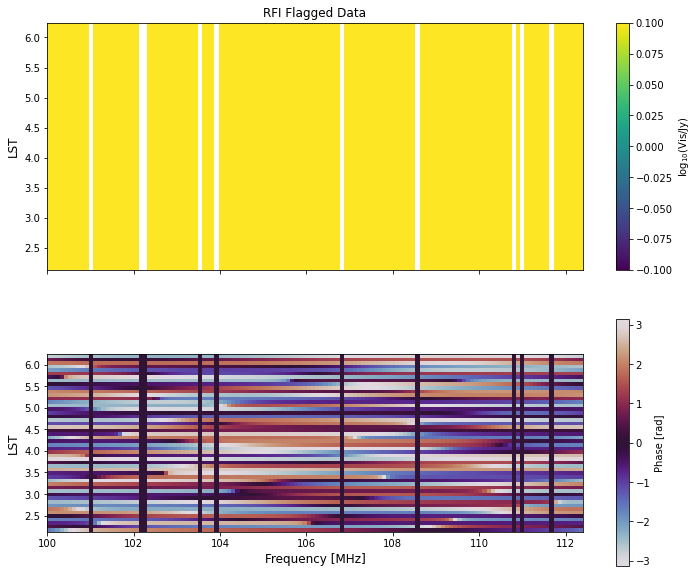

In [24]:
waterfall(uvd_flagged.data_array[:,0,:,0], title='RFI Flagged Data')

In [25]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()

# Load beam model
beamfile = '../data/HERA_NF_dipole_power.beamfits'

uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd_flagged.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd_flagged.data_array *= Jy_to_mK[None, None, :, None]

# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1_flagged = uvd_flagged.select(times=np.unique(uvd_flagged.time_array)[:-1:2], inplace=False)
uvd2_flagged = uvd_flagged.select(times=np.unique(uvd_flagged.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds_flagged = hp.PSpecData(dsets=[uvd1_flagged, uvd2_flagged], wgts=[None, None], beam=uvb)
# here we phase all datasets in dsets to the zeroth dataset
ds_flagged.rephase_to_dset(0)
# change units of UVData objects
ds_flagged.dsets[0].vis_units = 'mK'
ds_flagged.dsets[1].vis_units = 'mK'

# Specify which baselines to include
baselines_flagged = [(0,1)]

uvp_flagged = ds.pspec(baselines_flagged, baselines_flagged, (0, 1), [('xx', 'xx')], spw_ranges= None, 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)




Setting spectral range: (0, 128)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


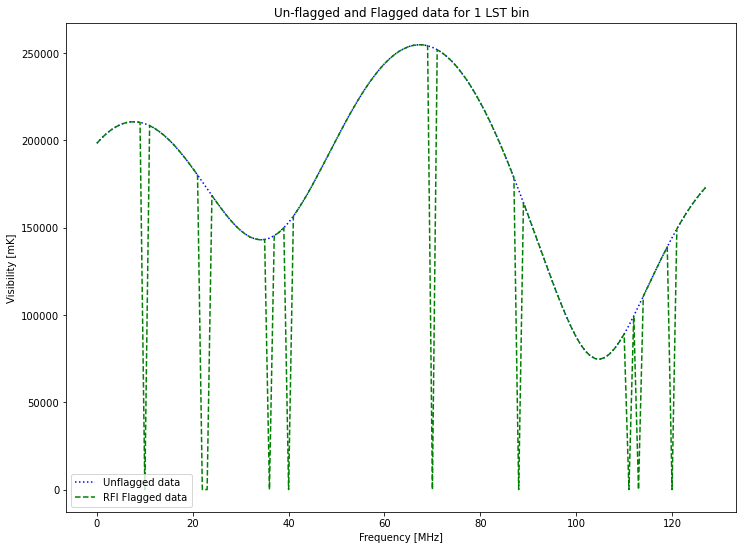

In [26]:
fig5 = plt.figure(figsize=(12,9))
plt.plot(np.abs(uvd.data_array[20,0,:,0]),'b:',label='Unflagged data')
plt.plot(np.abs(uvd_flagged.data_array[20,0,:,0]),'g--', label='RFI Flagged data')

plt.ylabel("Visibility [mK]")
plt.xlabel("Frequency [MHz]")
plt.title("Un-flagged and Flagged data for 1 LST bin")  ## in mK


plt.legend(loc='lower left')
# plt.savefig('./Plots/time-slice.png')


In [27]:
# fig6 = plt.figure(figsize=(12,9))
# plt.plot(np.abs(uvd_flagged.data_array[20,0,:,0]))
# plt.xlabel("Freq")
# plt.title("Flagged data for 1 time slice")  ## in mK

In [28]:
# blpairs_flagged = np.unique(uvp_flagged.blpair_array)
# # Unpack the list of baseline-pairs into a Python list
# blps_flagged = [blp for blp in blpairs_flagged]

# # Plot the spectra averaged over baseline-pairs and times
# ax_flagged = hp.plot.delay_spectrum(uvp_flagged, [blps_flagged,], spw=0, pol=('xx','xx'), 
#                                     average_blpairs=False, average_times=True)
# plt.title('Flagged data Power Spectrum')

### In-Painting data

In [29]:
# Creating a copy of UVData object for later use
# uvd_inpainted = copy.deepcopy(uvd_flagged)

#2D Data and flags
data = uvd_flagged.data_array[:,0,:,0]
flags = uvd_flagged.flag_array[:,0,:,0]
# sigma = 1
# nmax = 10
sigma = 1
nmax = 50

#Apllying Delay filter
model, model_coeff, data_out = uvtools.dspec.delay_filter_leastsq(data, flags, sigma, nmax, 
                                                                  add_noise = False)

# Replacing original data with in-painted data
# uvd_inpainted.data_array[:,0,:,0] = model 
uvd_inpainted.data_array[:,0,:,0] = data_out 

In [30]:
help(uvtools.dspec.delay_filter_leastsq)

Help on function delay_filter_leastsq in module uvtools.dspec:

delay_filter_leastsq(data, flags, sigma, nmax, add_noise=False, cn_guess=None, use_linear=True, operator=None)
    Fit a smooth model to each 1D slice of 2D complex-valued data with flags,
    using a linear least-squares solver. The model is a Fourier series up to a
    specified order. As well as calculating a best-fit model, this will also
    return a copy of the data with flagged regions filled in ('in-painted')
    with the smooth solution.
    
    Optionally, you can also add an uncorrelated noise realization on top of
    the smooth model in the flagged region.
    
    N.B. This is just a wrapper around delay_filter_leastsq_1d() but with some
    time-saving precomputations. It fits to each 1D slice of the data
    individually, and does not perform a global fit to the 2D data.
    
    Parameters
    ----------
    data : array_like, complex
        Complex visibility array as a function of frequency, with shape

In [31]:
# waterfall(uvd.data_array[:,0,80:81,0], title=' Unflagged Data ')

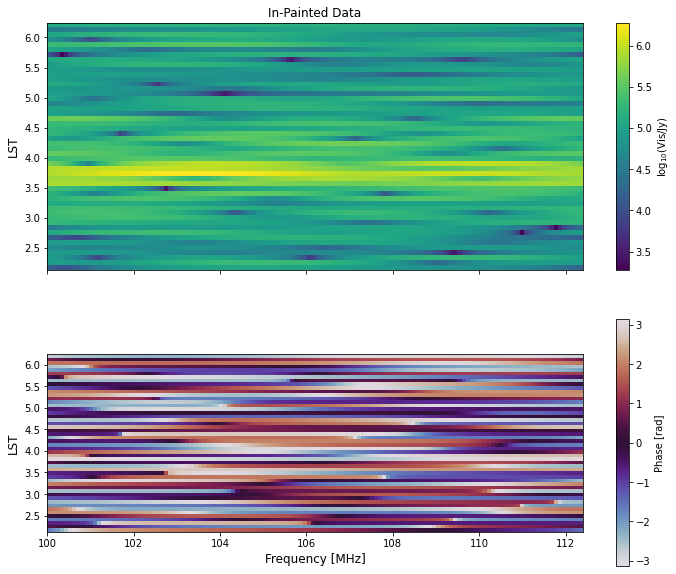

In [32]:
waterfall(uvd_inpainted.data_array[:,0,:,0], title='In-Painted Data')

In [33]:
# fig7 = plt.figure(figsize=(12,9))
# plt.plot(np.abs(uvd.data_array[20,0,:,0]))
# plt.xlabel("Freq")
# plt.yscale('log')
# plt.title("Unflagged data for 1 time slice")  ## in mK

In [34]:
# fig8 = plt.figure(figsize=(12,9))
# plt.plot(np.abs(uvd_inpainted.data_array[20,0,:,0]))
# plt.xlabel("Freq")
# plt.title("In-Painted data for 1 time slice")  ## already in mK

Text(0.5, 1.0, 'Model for 1 LST bin')

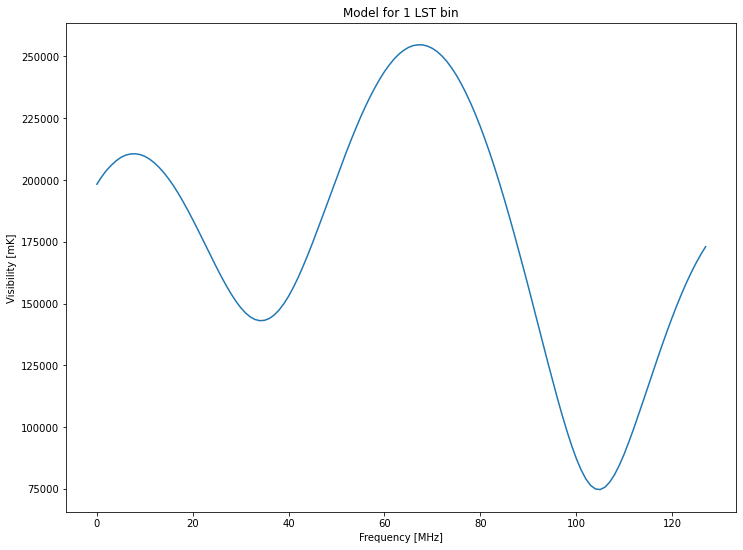

In [35]:
fig9 = plt.figure(figsize=(12,9))
plt.plot(np.abs(model[20,:]))
plt.ylabel("Visibility [mK]")
plt.xlabel("Frequency [MHz]")
# plt.yscale("log")
plt.title("Model for 1 LST bin")

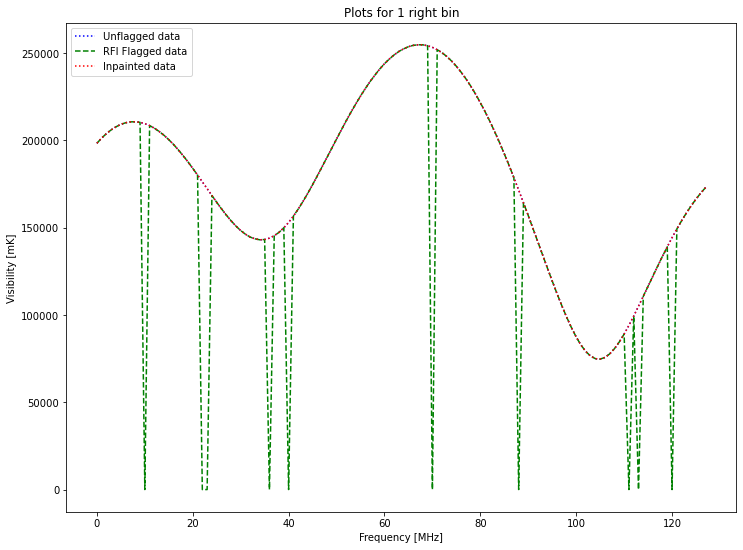

In [36]:
fig10 = plt.figure(figsize=(12,9))
plt.plot(np.abs(uvd.data_array[20,0,:,0]),'b:',label='Unflagged data')
plt.plot(np.abs(uvd_flagged.data_array[20,0,:,0]),'g--', label='RFI Flagged data')
plt.plot(np.abs(uvd_inpainted.data_array[20,0,:,0]), 'r:', label='Inpainted data')

plt.ylabel("Visibility [mK]")
plt.xlabel("Frequency [MHz]")
plt.title("Plots for 1 right bin")  ## in mK
plt.legend(loc='upper left')
# plt.savefig('./Plots/time-slice.png')

Text(0.5, 1.0, 'Difference of model and Unflagged data for 1 LST bin')

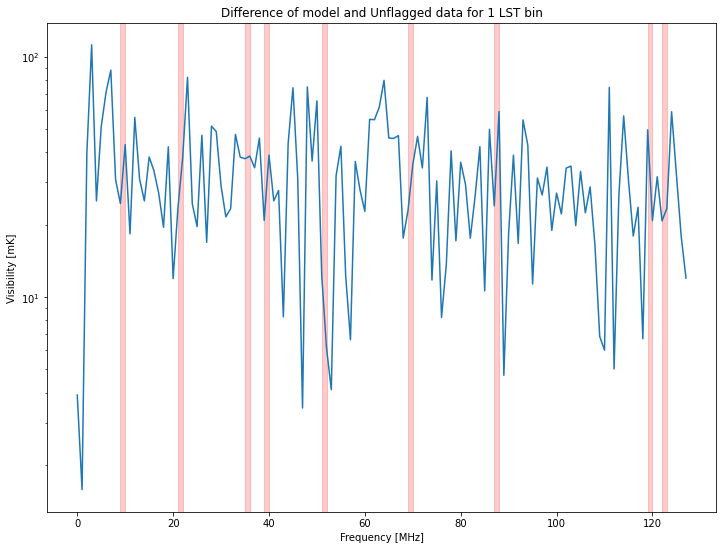

In [37]:
fig11 = plt.figure(figsize=(12,9))
modeldiff_abs = np.abs(np.subtract(model[20,:],uvd.data_array[20,0,:,0]))
plt.plot(modeldiff_abs)
plt.yscale('log')
plt.axvspan(9, 10, alpha=0.2, color='red')
plt.axvspan(21, 22, alpha=0.2, color='red')
plt.axvspan(35, 36, alpha=0.2, color='red')
plt.axvspan(39, 40, alpha=0.2, color='red')
plt.axvspan(51, 52, alpha=0.2, color='red')
plt.axvspan(69, 70, alpha=0.2, color='red')
plt.axvspan(87, 88, alpha=0.2, color='red')
plt.axvspan(119, 120, alpha=0.2, color='red')
plt.axvspan(122, 123, alpha=0.2, color='red')
plt.ylabel("Visibility [mK]")
plt.xlabel("Frequency [MHz]")
plt.title('Difference of model and Unflagged data for 1 LST bin')
# plt.savefig('./Plots/difference-model.png')

In [38]:
modeldiff_arr_abs = np.abs(np.subtract(model[:,:],uvd.data_array[:,0,:,0]))

In [39]:
np.shape(modeldiff_arr_abs)

(50, 128)

In [40]:
avg_noise = np.mean(modeldiff_arr_abs, axis=0)

In [41]:
np.shape(avg_noise)

(128,)

In [42]:
# sim.data.data_array[:,0,17:18,0] = 0 ### NO noise Flags
# sim.data.data_array[:,0,46:47,0] = 0
# sim.data.data_array[:,0,58:59,0] = 0
# sim.data.data_array[:,0,74:75,0] = 0 
# sim.data.data_array[:,0,4:5,0] = 0 
# sim.data.data_array[:,0,92:93,0] = 0
# sim.data.data_array[:,0,111:112,0] = 0
# sim.data.data_array[:,0,117:118,0] = 0
# sim.data.data_array[:,0,26:27,0] = 0

Text(0.5, 1.0, 'Average (over 50 LST bins) of residual')

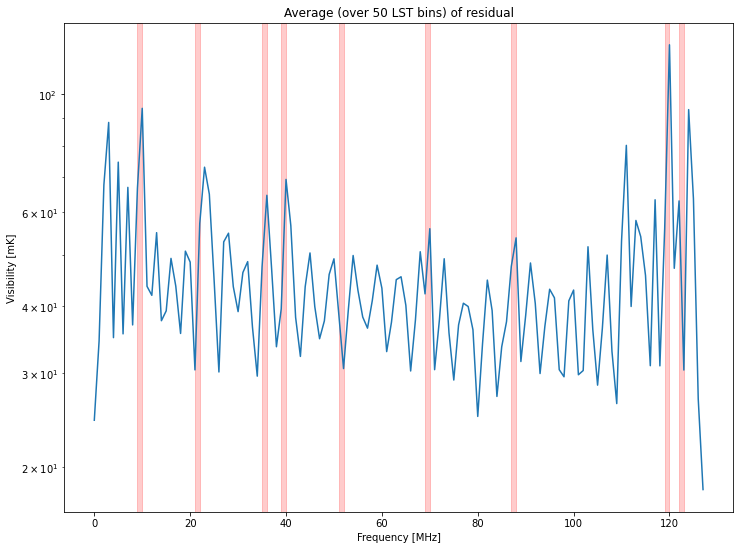

In [43]:
fig12 = plt.figure(figsize=(12,9))
plt.plot(avg_noise)
plt.axvspan(9, 10, alpha=0.2, color='red')
plt.axvspan(21, 22, alpha=0.2, color='red')
plt.axvspan(35, 36, alpha=0.2, color='red')
plt.axvspan(39, 40, alpha=0.2, color='red')
plt.axvspan(51, 52, alpha=0.2, color='red')
plt.axvspan(69, 70, alpha=0.2, color='red')
plt.axvspan(87, 88, alpha=0.2, color='red')
plt.axvspan(119, 120, alpha=0.2, color='red')
plt.axvspan(122, 123, alpha=0.2, color='red')
plt.ylabel("Visibility [mK]")
plt.xlabel("Frequency [MHz]")
plt.yscale('log')
plt.title('Average (over 50 LST bins) of residual')
# plt.savefig('./Plots/avg_residual_NoNoise.png')

In [44]:
std_noise = np.std(modeldiff_arr_abs, axis=0)

In [45]:


# sim.data.data_array[:,0,10:11,0] = 0
# sim.data.data_array[:,0,22:23,0] = 0
# sim.data.data_array[:,0,36:37,0] = 0
# sim.data.data_array[:,0,40:41,0] = 0 
# sim.data.data_array[:,0,52:53,0] = 0 
# sim.data.data_array[:,0,70:71,0] = 0
# sim.data.data_array[:,0,88:89,0] = 0
# sim.data.data_array[:,0,120:121,0] = 0
# sim.data.data_array[:,0,123:124,0] = 0

Text(0.5, 1.0, 'Standard deviation (over 50 LST bins) of residual')

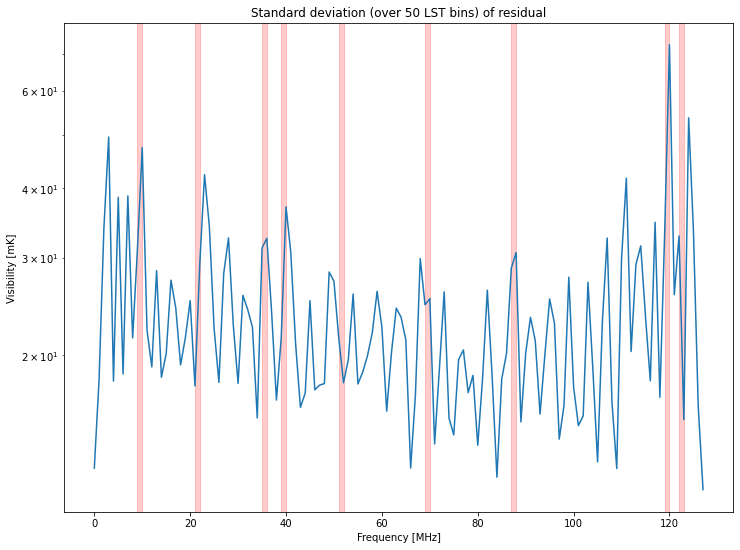

In [46]:
fig122 = plt.figure(figsize=(12,9))
plt.plot(std_noise)
plt.axvspan(9, 10, alpha=0.2, color='red')
plt.axvspan(21, 22, alpha=0.2, color='red')
plt.axvspan(35, 36, alpha=0.2, color='red')
plt.axvspan(39, 40, alpha=0.2, color='red')
plt.axvspan(51, 52, alpha=0.2, color='red')
plt.axvspan(69, 70, alpha=0.2, color='red')
plt.axvspan(87, 88, alpha=0.2, color='red')
plt.axvspan(119, 120, alpha=0.2, color='red')
plt.axvspan(122, 123, alpha=0.2, color='red')
plt.ylabel("Visibility [mK]")
plt.xlabel("Frequency [MHz]")
plt.yscale('log')
plt.title('Standard deviation (over 50 LST bins) of residual')
# plt.savefig('./Plots/avg_residual_NoNoise.png')

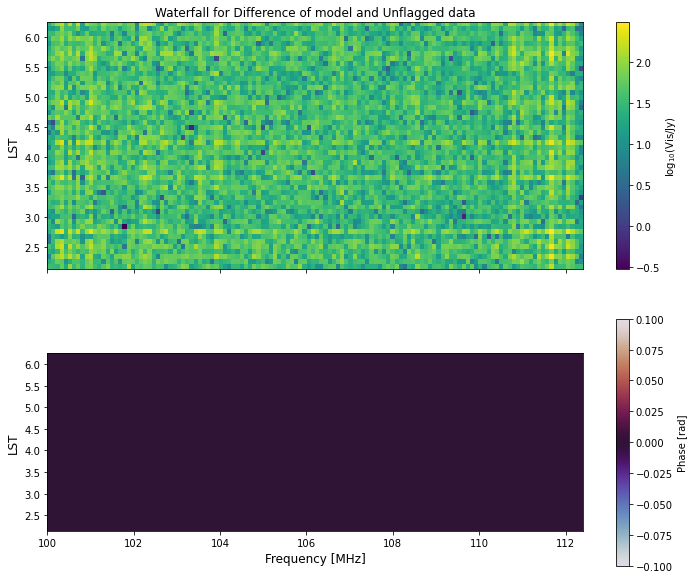

In [47]:
waterfall(modeldiff_arr_abs[:,:], title='Waterfall for Difference of model and Unflagged data')
# plt.savefig('./Plots/modeldiff_waterfall.png')

Text(0.5, 1.0, 'Difference of in-painted and Unflagged data for 1 LST bin')

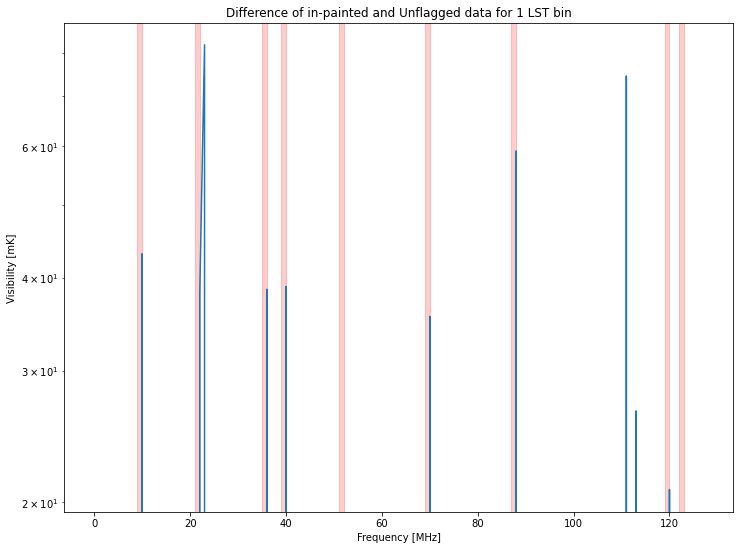

In [48]:
fig13 = plt.figure(figsize=(12,9))
datadiff_absdiff = np.abs(np.subtract(uvd_inpainted.data_array[20,0,:,0],uvd.data_array[20,0,:,0]))
plt.plot(datadiff_absdiff)
plt.axvspan(9, 10, alpha=0.2, color='red')
plt.axvspan(21, 22, alpha=0.2, color='red')
plt.axvspan(35, 36, alpha=0.2, color='red')
plt.axvspan(39, 40, alpha=0.2, color='red')
plt.axvspan(51, 52, alpha=0.2, color='red')
plt.axvspan(69, 70, alpha=0.2, color='red')
plt.axvspan(87, 88, alpha=0.2, color='red')
plt.axvspan(119, 120, alpha=0.2, color='red')
plt.axvspan(122, 123, alpha=0.2, color='red')
plt.yscale('log')
plt.ylabel("Visibility [mK]")
plt.xlabel("Frequency [MHz]")
plt.title("Difference of in-painted and Unflagged data for 1 LST bin")
# plt.savefig('./Plots/difference-model.png')

In [49]:
np.mean(datadiff_absdiff)


3.572352770183143

In [50]:
np.std(datadiff_absdiff)

13.364286563205228

divide by zero encountered in log10


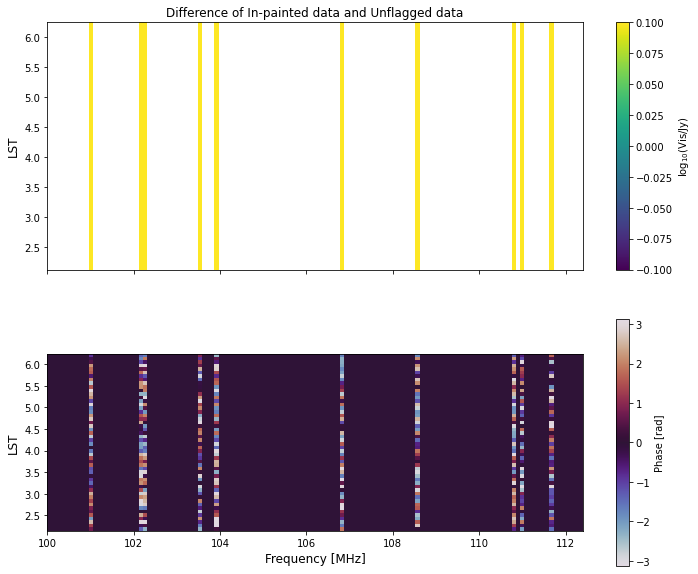

In [51]:
diff_data = (( uvd_inpainted.data_array[:,0,:,0] - uvd.data_array[:,0,:,0]))
waterfall(diff_data, title='Difference of In-painted data and Unflagged data')

In [52]:
cosmo = hp.conversions.Cosmo_Conversions()
# Load beam model
beamfile = '../data/HERA_NF_dipole_power.beamfits'

uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# find conversion factor from Jy to mK
#Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd_inpainted.freq_array), pol='XX')


# reshape to appropriately match a UVData.data_array object and multiply in!
#uvd_inpainted.data_array *= Jy_to_mK[None, None, :, None]


# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1_inpainted = uvd_inpainted.select(times=np.unique(uvd_inpainted.time_array)[:-1:2], inplace=False)
uvd2_inpainted = uvd_inpainted.select(times=np.unique(uvd_inpainted.time_array)[1::2], inplace=False)


# Create a new PSpecData object
ds_inpainted = hp.PSpecData(dsets=[uvd1_inpainted, uvd2_inpainted], wgts=[None, None], beam=uvb)
ds_inpainted.rephase_to_dset(0) # Phase to the zeroth dataset


# change units of UVData objects
ds_inpainted.dsets[0].vis_units = 'mK'
ds_inpainted.dsets[1].vis_units = 'mK'


# Specify which baselines to include
baselines_inpainted = [(0,1)]


uvp_inpainted = ds_inpainted.pspec(baselines_inpainted, baselines_inpainted, (0, 1), [('xx', 'xx')], spw_ranges= None, 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)



Setting spectral range: (0, 128)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


In [53]:
uvp_inpainted.units

'(mK)^2 h^-3 Mpc^3'

Text(0.5, 1.0, 'In-Painted data Power Spectrum')

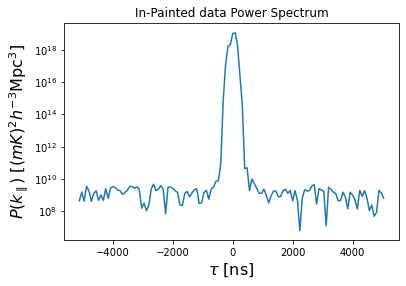

In [54]:
# plt.figure(figsize=(12,9))
blpairs_inpainted = np.unique(uvp_inpainted.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps_inpainted = [blp_new for blp_new in blpairs_inpainted]

# Plot the spectra averaged over baseline-pairs and times
ax_inpainted = hp.plot.delay_spectrum(uvp_inpainted, [blps_inpainted,], spw=0, pol=('xx','xx'), 
                            average_blpairs=False, average_times=True)
plt.title('In-Painted data Power Spectrum')

Text(0.5, 1.0, 'Delay Power Spectrum: 30% RFI occupancy')

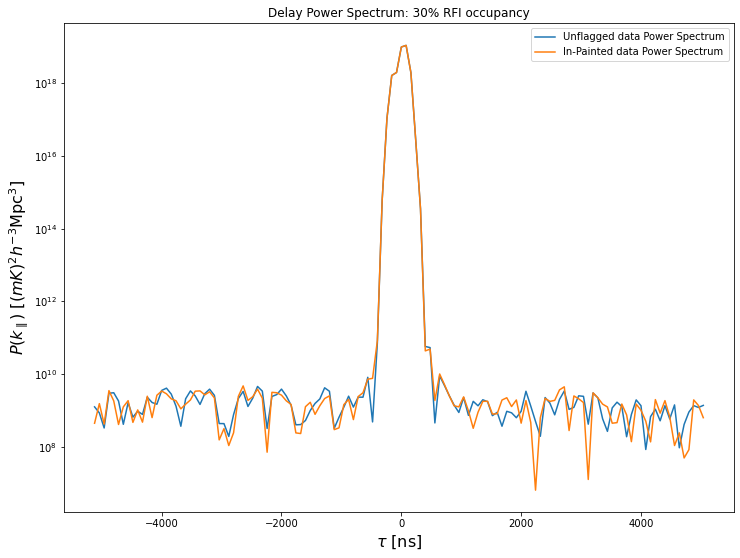

In [55]:
fig14 = plt.figure(figsize=(12,9))
ax14 = fig14.add_subplot(111)
ax = hp.plot.delay_spectrum(uvp, [blps,], spw=0, pol=('xx','xx'), 
                            average_blpairs=False, average_times=True, ax = ax14)

hp.plot.delay_spectrum(uvp_inpainted, [blps_inpainted,], spw=0, pol=('xx','xx'), 
                            average_blpairs=False, average_times=True, ax=plt.gca())
ax14.legend(['Unflagged data Power Spectrum','In-Painted data Power Spectrum'], loc = 'upper right')
ax14.set_title('Delay Power Spectrum: 30% RFI occupancy')


In [56]:
pspec_unflg = ax_unflg.gca().get_lines()[0].get_ydata()
pspec_inpainted = ax_inpainted.gca().get_lines()[0].get_ydata()
pspec_delay = ax_unflg.gca().get_lines()[0].get_xdata()

pspec_absdiff = np.abs(np.subtract(pspec_unflg,pspec_inpainted))
pspec_fracdiff = np.divide(pspec_absdiff,pspec_unflg)

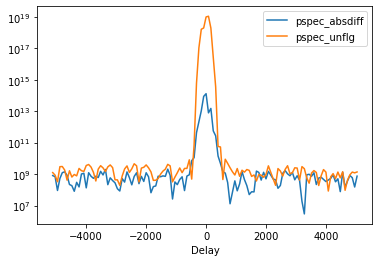

In [57]:
plt.plot(pspec_delay,pspec_absdiff, label = 'pspec_absdiff')
plt.plot(pspec_delay,pspec_unflg, label = 'pspec_unflg')
plt.xlabel('Delay')
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'Fractional Difference of power spectra of In-Painted and Unflagged data')

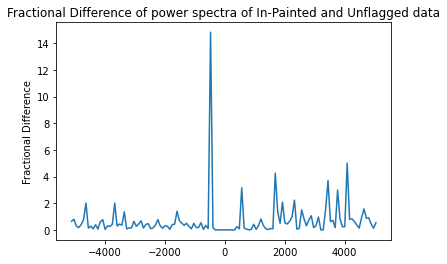

In [58]:
plt.plot(pspec_delay,pspec_fracdiff)
plt.ylabel('Fractional Difference')
plt.title('Fractional Difference of power spectra of In-Painted and Unflagged data')

In [59]:
 a = np.array([[2, 4], [10, 20], [10, 20]])
a

array([[ 2,  4],
       [10, 20],
       [10, 20]])

In [60]:
avg = np.mean(a, axis=0)

In [61]:
a

array([[ 2,  4],
       [10, 20],
       [10, 20]])

In [62]:
a.shape

(3, 2)

In [63]:
avg.shape

(2,)

In [64]:
avg

array([ 7.33333333, 14.66666667])

In [65]:
22/3

7.333333333333333

In [66]:
fqs = 128
lsts = 50
Tsky = 180
mfreq = 0.18
index = -2.5
tsky = Tsky * (fqs / mfreq) ** index  # default to a scalar
tsky = np.resize(tsky, (lsts, fqs))

In [67]:
tsky.size

6400

In [68]:
noise_vis[:,0,:,0].shape

(50, 128)

In [69]:
aa = np.std(noise_vis[:,0,:,0], axis = 0)

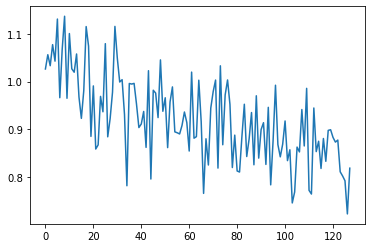

In [70]:
plt.plot(aa)

#### 